# Smoothed boxcar filter

Define boxcar filter in frequency domain, of width $w$ as
$$\hat{S}(\xi) = \text{Indicator}\left(|\xi| \leq w/2\right).$$

In time domain, it is the sinc function:
$$S_t = \int_{-1/2}^{1/2} \hat{S}(\xi) e^{2\pi i \xi t} d\xi = \frac{\sin(\pi t w)}{\pi t}.$$

We want to convolve with $\hat{S}$ and sample the result $\hat{x} \star \hat{S}$ at $B$ uniformly spaced points in $[0,1)$. Note that $B$ is the number of bins.

This means we want to multiply with sinc function in the time domain. To be able to truncate in time domain, we want to multiply the sinc function with a Gaussian, which means in the frequency domain, we want to smooth the boxcar filter by convolving with a Gaussian.

Let $0 < \kappa \leq 1$ and $\delta>0$. The latter controls the error due to truncation in time domain.

Let the width of the window be $w=(1-\kappa/2)/B$. The window we want to use would be
$$W_t = e^{-t^2/2\sigma_t^2} S_t$$
and in frequency domain, it can be shown that
$$\hat{W}(\xi) = \frac{1}{\sigma_f \sqrt{2\pi}} \int_{I_{\xi}} e^{-\eta^2/2\sigma_f^2} d\eta$$
where $\sigma_f = \frac{\kappa}{4B\sqrt{2 c_{\delta}}}$ and $\sigma_t = \frac{1}{2\pi \sigma_f} = O(\frac{B \sqrt{c_{\delta}}}{\kappa})$ and $I_{\xi} = \cup_{j\in \mathbb{Z}} [\xi+j - w/2, \xi+j + w/2]$.

## Truncation in time

The exact window used would be truncated in time domain. The support would be of size $2 \sqrt{2 c_{\delta}} \sigma_t + 1= O(B c_{\delta}/\kappa)$.

It can be shown that in frequency domain, we lose very very little when we work with this time-truncated window.

## Approximating in frequency domain

Anothing thing we need is to approximate $\hat{W}(\xi)$ well when $\xi$ is inside the bin $[-1/2B, 1/2B]$.

Our approximant would be $$\hat{W}'(\xi) = \frac{1}{\sigma_f \sqrt{2\pi}} \int_{\xi-w/2}^{\xi+w/2} e^{-\eta^2/2\sigma_f^2} d\eta.$$

Essentially, we take only one interval inside $I_{\xi}$ and ignore the rest because the integrand is really tiny, when under the assumption that $\xi$ is close to the origin. This approximant $\hat{W}'(\xi)$ can be easily evaluated using erf functions.

In [57]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

def window(n, b, delta):
    """Returns wt, wf which is window in time and freq domains. delta controls error."""
    assert (n % 2) == 1  # For now, assume an odd n.
    n2 = (n - 1) / 2
    kappa = 0.5
    w = (1 - 0.5 * kappa) / b
    c_delta = -np.log(delta)
    sigma_t = (2 * b * np.sqrt(2 * c_delta)) / (np.pi * kappa)
    sigma_f = 1.0 / (2.0 * np.pi * sigma_t)

    # We use [-n2, n2] instead of [0, n-1] to more easily compute the window in time domain.
    t = np.arange(-n2, n2 + 1).astype(float)
    q = t / sigma_t  # Temp variable.
    wt = np.exp(-0.5 * q * q) * (w * np.sinc(t * w))
    # The ifftshift is to move from [-n2, n2] to [0, n-1] in time domain before we can do the FFT.
    # The fftshift is to move from [0, n-1] to [-n2, n2] in frequency domain for better visualization.
    wf = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(wt)))
    
    # In time domain, we truncate so that convolution is cheap and scale with b not n.
    p = int(np.ceil(2 * np.sqrt(2 * c_delta) * sigma_t + 1))
    if (p % 2) == 0:
        p += 1
    p2 = (p - 1) / 2
    mask = np.abs(t) <= p2
    wt_truncated = wt.copy()
    wt_truncated[~mask] = 0
    wf_truncated = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(wt_truncated)))
    
    # We also need a closed form for approximating wf. We only care about the region inside the bin.
    
    assert np.sum(np.abs(np.imag(wf))) < 1e-5
    assert np.sum(np.abs(np.imag(wf_truncated))) < 1e-5
    
    # Next, we compute our approximant function in frequency domain.
    xi = 0.5 * t / n2
    tmp = 1.0 / (np.sqrt(2) * sigma_f)
    wf_approx = 0.5 * (erf((xi + 0.5 * w) * tmp) - erf((xi - 0.5 * w) * tmp))
    
    return wt, np.real(wf), wt_truncated, np.real(wf_truncated), wf_approx, t, xi

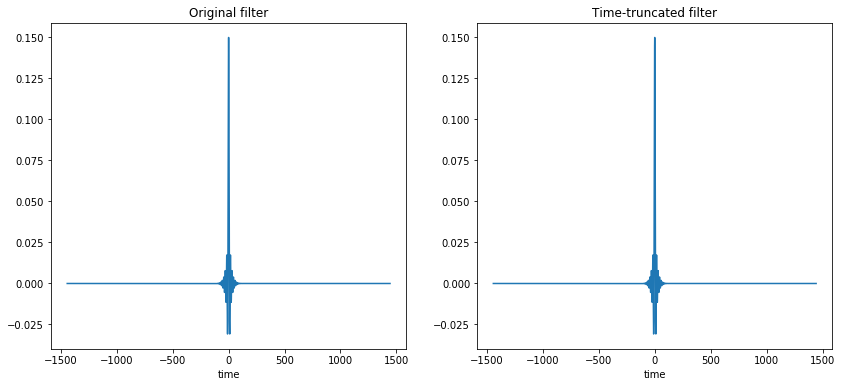

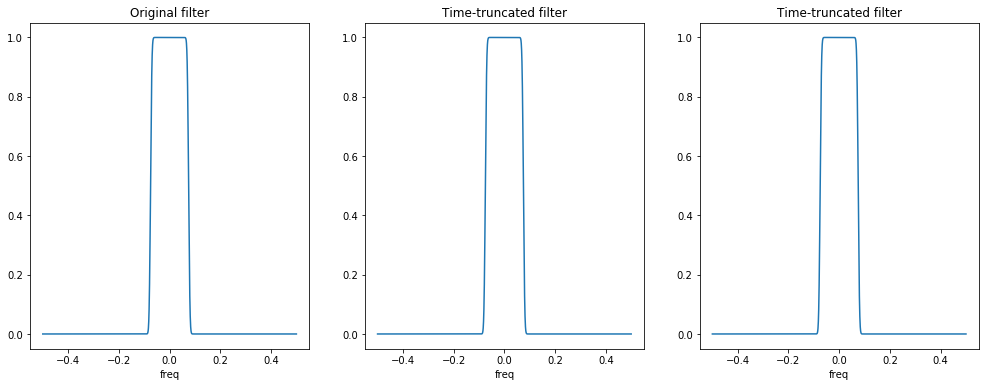

Mean L1 error for time-truncated: 1.665079e-11
Mean L1 error for approximant: 5.195705e-05


In [64]:
def experiment():
    n = 2887  # Prime. Not needed here.
    b = 5
    wt, wf, wt_truncated, wf_truncated, wf_approx, t, xi = window(n, b, 1e-8)
    
    f, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].plot(t, wt)
    axs[0].set_title('Original filter')
    axs[0].set_xlabel('time')
    axs[1].plot(t, wt_truncated)
    axs[1].set_title('Time-truncated filter')
    axs[1].set_xlabel('time')
    plt.show()
    
    f, axs = plt.subplots(1, 3, figsize=(17, 6))
    axs[0].plot(xi, wf)
    axs[0].set_title('Original filter')
    axs[0].set_xlabel('freq')
    axs[1].plot(xi, wf_truncated)
    axs[1].set_title('Time-truncated filter')
    axs[1].set_xlabel('freq')
    axs[2].plot(xi, wf_approx)
    axs[2].set_title('Time-truncated filter')
    axs[2].set_xlabel('freq')
    plt.show()
    
    err = np.sum(np.abs(wf - wf_truncated)) / n
    print 'Mean L1 error for time-truncated: %e' % err
    
    err = np.sum(np.abs(wf - wf_approx)) / n
    print 'Mean L1 error for approximant: %e' % err

    
experiment()

Observe that in time domain, the filter decays really fast and we can truncate to a support that is $O(b)$ where $b$ is number of bins.